# Machine Learning: PANDA Accelerator Data

## Authors: Chourmouzios Chourmouziadis (s4834909), Matias Santacruz Vallejo (s4783190), Lucio Vecchia (s4662822), Ruxandra Nastase (s4900294)

In [1]:
import pandas as pd                                  
import numpy as np

import requests                                      # Used to read data from URL address 

import matplotlib.pyplot as plt                      
from matplotlib.colors import ListedColormap         # Used for decision surface plots
import matplotlib as mpl

import seaborn as sns                                 # For plotting heatmaps and correlation matrix

from sklearn import tree                             # Classifier decision trees
from sklearn import neighbors                        # Classifier kNN
from sklearn.ensemble import RandomForestClassifier  # Classifier Random Forest
from sklearn.neural_network import MLPClassifier     # Classifier multi-layer perceptron
from random import uniform as random_uniform         # Random number generator for randomizing train/test samples

from IPython.core.display import Image               # For displaying images in notebook, used for decision tree pictures
from six import StringIO                             # To write string buffers as files, used for making decision tree pictures
import re
import io
import VisualizeNN as VisNN

from sklearn import cluster                        


pd.set_option('mode.chained_assignment', None)      # Getting rid of large warnings

mpl.rcParams.update({'font.size': 18, 'font.family': 'serif', 'xtick.major.pad' : 5, 'ytick.major.pad' : 5})

## Visualization Study

In [2]:
# Loading our data in its raw form

urlGam = "https://drive.google.com/uc?export=download&id=1TvbbCV-kJeNMuIORMyiMFgH_u_CQSZhX"
downloadGam = requests.get(urlGam).content
GamRaw = pd.read_csv(io.StringIO(downloadGam.decode('utf-8')))

urlNeut = "https://drive.google.com/uc?export=download&id=1bY6ZPF3WLxfviYSSViuw1SEx1_sWxP46"
downloadNeut = requests.get(urlNeut).content
NeutRaw = pd.read_csv(io.StringIO(downloadNeut.decode('utf-8')))

In [3]:
# Making the training data sets

GamTrain = GamRaw.sample(frac=0.1)
NeutTrain = NeutRaw.sample(frac=0.1)

# Add a distriction column to the data, to know which is gam and which is neut for later graphing and training

GamTrain["distinction"] = 1
NeutTrain["distinction"] = 0

In [4]:
# Combining Neut and Gam dataframes into a single dataframe

plotFrame = pd.concat([GamTrain, NeutTrain], ignore_index=True, axis=0)

print(plotFrame.shape)
plotFrame.head(-1)

(8687, 12)


Th         Ph         E  NrHits  NrBumps        E1      E1E9  \
0      28.4262 -128.97800  1.423540      15        1  1.039230  0.764970   
1      90.7214   13.30380  3.408250      23        1  1.635780  0.502705   
2      73.5401 -125.17600  4.661950      27        1  2.468550  0.549270   
3     115.3460   18.36160  3.557100      22        1  2.745240  0.802923   
4     124.3640   -4.81919  2.094480      19        1  0.972707  0.512158   
...        ...        ...       ...     ...      ...       ...       ...   
8681  160.6040  165.85300  1.276250      21        2  0.392041  0.545586   
8682  150.0460  119.46600  0.494949       7        1  0.306025  0.642362   
8683  128.3790   93.56060  0.675080       6        1  0.295677  0.518993   
8684   72.6931 -165.76100  1.690870      30        1  0.904766  0.621313   
8685   26.3213  -75.39800  0.991258      17        1  0.536738  0.585215   

         E9E25       Z20       Z53    LatMom  distinction  
0     0.969270  0.957903  0.001009  0.956795            1  
1     0.965499  0.964985  0.001822  0.408536            1  
2     0.972677  0.972463  0.002437  0.435171            1  
3     0.970932  0.977234  0.001847  0.289214            1  
4     0.915404  0.964833  0.003543  0.382557            1  
...        ...       ...       ...       ...          ...  
8681  0.665213  0.807070  0.050839  0.880243            0  
8682  1.000000  0.936382  0.005277  0.864174            0  
8683  0.853063  0.961985  0.005523  0.303072            0  
8684  0.921641  0.901573  0.012193  0.941142            0  
8685  0.949869  0.950963  0.009431  0.558229            0  

[8686 rows x 12 columns]

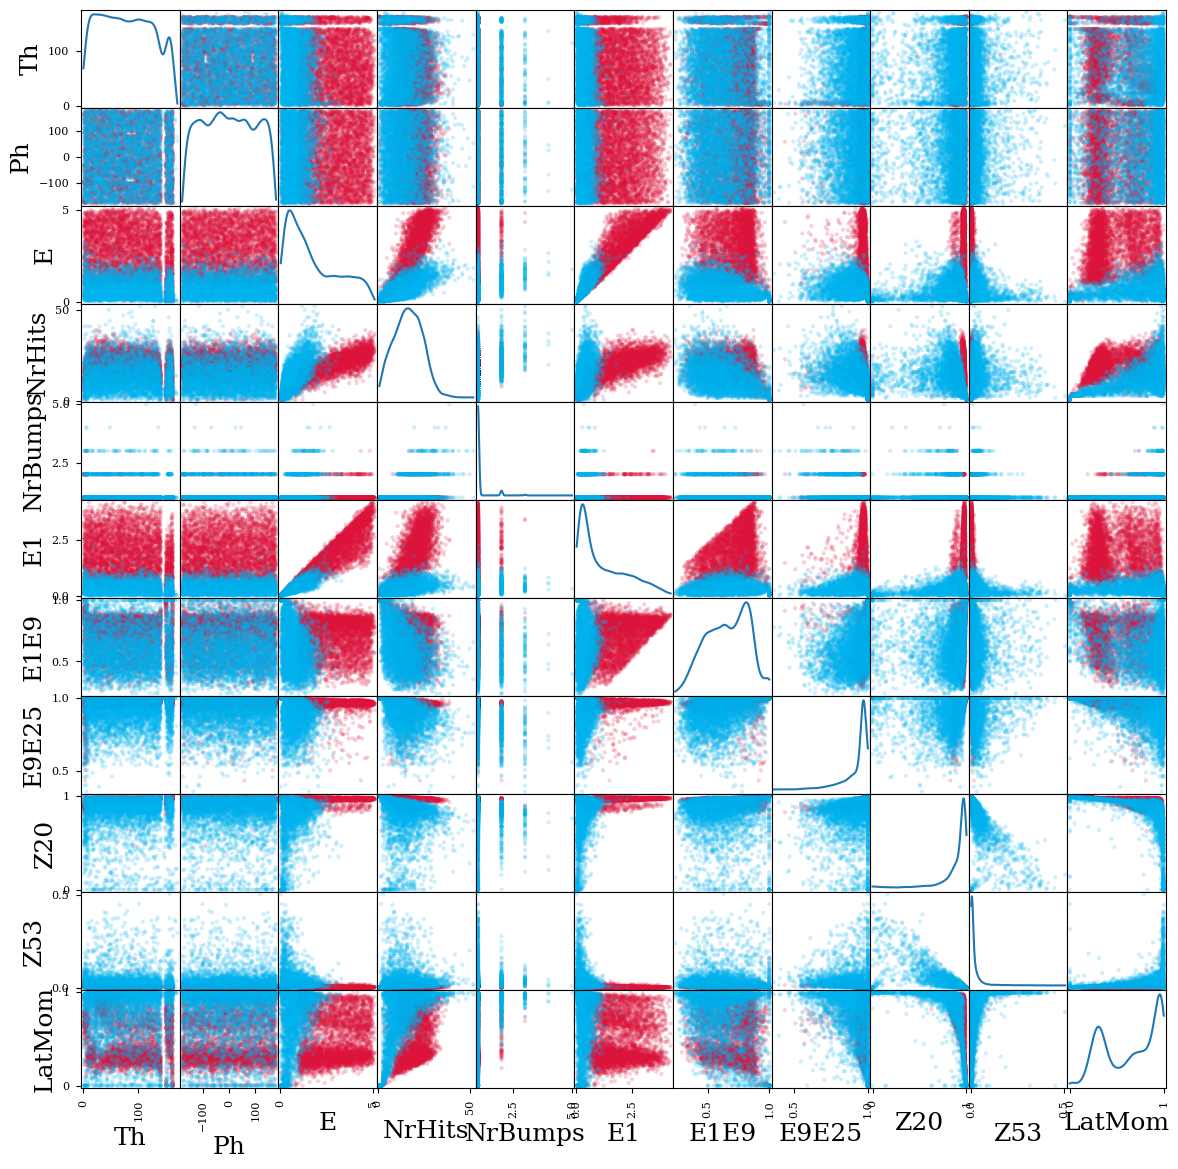

In [5]:
colors = ['#DC143C', '#00B2EE']        # RED colour('#DC143C')  = Gamma Rays (photons)
                                       # BLUE colour('#00B2EE') = Neutrons

_ = pd.plotting.scatter_matrix(plotFrame[['Th','Ph','E','NrHits','NrBumps','E1','E1E9','E9E25','Z20','Z53','LatMom']], 
                               figsize=(14,14), 
                               diagonal='kde', 
                               alpha=0.2, 
                               color=[colors[x-1] for x in list(plotFrame.distinction)])


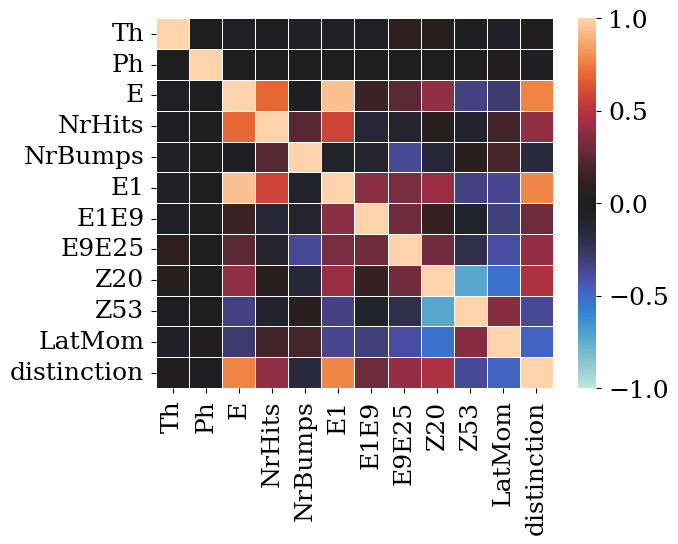

<Figure size 50000x50000 with 0 Axes>

In [6]:
# Heatmap to visualize data correlations

sns.heatmap(plotFrame.corr(), 
            annot=False,
            linewidths=0.5,
            vmin=-1,
            vmax=1,
            center=0,
            cbar=True)

plt.figure(figsize=(500, 500))
plt.show()

We are trying to find the most important or useful features to apply the machine learning algorithms on. Ideally, we want data where the neutrons and protons can be easily distinguished to train the model; we can see this from the matrix plot. We decided that E, E1, NrHits and Z20 were good features to use for the following reasons:
- There were clear clusters and few anomalies.
- The neutron and photon data did not overlap much, except close to the cluster border.
- They compare well with eachother in terms of correlation.

## Machine Learning Classifier Functions and Data Cleaning

In [7]:

def NormalizeData(data, feature_list):
    """
    Normalize features in "feature_list" of dataFrame "data". New features will be added as columns to 
    the dataFrame with label "_normal".
    
    Params:
        data (pandas dataframe): Dataframe with target data
        feature_list (list): Columns to normalize
    
    Returns:
        The function returns the updated table.
    """
    
    # Dont modify the original dataFrame "data"
    data_tmp = data.copy()

    # Run over all features and create new column with "_normal"
    for feature in feature_list:
        feature_new = feature + "_normal"
        data_tmp[feature_new] = (data_tmp[feature] - data_tmp[feature].mean()) / data_tmp[feature].std()

    # Return the updated dataFrame
    return data_tmp


In [8]:
# Normalise features to corrolate

plotFrame = NormalizeData(plotFrame, ["E", "NrHits", "E1", "LatMom"])

# Check that normalization makes sense
plotFrame[["E_normal", "NrHits_normal", "E1_normal", "LatMom_normal"]].describe()

E_normal  NrHits_normal     E1_normal  LatMom_normal
count  8.687000e+03   8.687000e+03  8.687000e+03   8.687000e+03
mean   2.617402e-17  -1.963051e-17  1.308701e-17   1.570441e-16
std    1.000000e+00   1.000000e+00  1.000000e+00   1.000000e+00
min   -1.283016e+00  -2.076061e+00 -1.100250e+00  -2.112660e+00
25%   -8.483433e-01  -7.572307e-01 -8.205780e-01  -9.840330e-01
50%   -3.133361e-01   3.406764e-02 -3.958156e-01   1.795122e-01
75%    7.753029e-01   6.934829e-01  7.239400e-01   1.001556e+00
max    2.333769e+00   4.649974e+00  2.957480e+00   1.255013e+00

In [9]:

def Classify(classifier, data, params,
             prop_test=0.5, feature_list=['E_normal','NrHits_normal'], 
             plot_ds=False, plot_tree=False, plot_network=False):
    '''
    Use "classifier" algorithm to classify dataset data based of certain features of the data
    
    Params:
        classifier (str): Classifier to use
        data (pandas dataframe): Dataframe with all accessible data
        params (list): Classifier parameters
        prop_test (float): Fraction of the test data from data
        feature_list (list): Features to train model on
        plot_ds(bool): Plot decision surface
        plot_tree(bool): Plot tree
        plot_network(bool): Plot network

    Returns:
        Updated dataset including a column with predicted class
    '''
    
    
    assert 0<prop_test<1
     
    # make a copy of the dataframe
    data_tmp = data.copy()

    # Add a column specifying whether event is used for training or for testing
    data_tmp['is_train'] = np.random.uniform(0, 1, len(data_tmp)) <= (1-prop_test)

    # Extract two seperate datasets for training (train) and testing (test)
    train, test = data_tmp[data_tmp['is_train']==True], data_tmp[data_tmp['is_train']==False]
    
    
    if   (classifier=="DT"):
        # Instance of Decision Tree Classifier.
        clf = tree.DecisionTreeClassifier(criterion='entropy',
                                          min_impurity_decrease=params[0],
                                          max_depth=params[1])
    elif (classifier=="RF"):
        # Instance of Random Forest Classifier.
        clf = RandomForestClassifier(n_estimators=params[0], 
                                     max_features=params[1]) # CHANGED HERE
    elif (classifier=="kNN"):
        # Instance of kNN Classifier.
        clf = neighbors.KNeighborsClassifier(n_neighbors=params[0])
    elif (classifier=="MLP"):
        # Instance of MLP Classifier.
        clf = MLPClassifier(solver='lbfgs', activation='logistic', #solver=quasi-Newton, activation=sigmoid
                            max_iter=5000, 
                            hidden_layer_sizes=params[0])
    else:
        print(" Classifier not implemented: ", classifier)
        return None
    
    # Fit the data with the selected classifier
    clf.fit(train[feature_list], train['distinction'])
    
    # Evaluate the training points
    trainpred = clf.predict(train[feature_list]) # majority vote result
    train['prediction'] = [x for x in trainpred]
   
    # Predict on the testing points       
    testpred = clf.predict(test[feature_list])   # majority vote result
    test['prediction'] = [x for x in testpred]
 
    data_update = pd.concat([train, test])
     
    # Plot the decision surface if plot_ds flag set to True and nr of features equals 2.
    if (plot_ds) & (len(feature_list)==2):
        PlotDecisionSurface(clf,data_update,feature_list,title=classifier)

    # In the case the classifier is a decision tree, allow for the possibility to plot 
    # the tree if set to True
    if (plot_tree) & (classifier=="DT"): 
        PlotTree(clf, feature_list)
  
    # Return the updated version of the dataFrame including labels "is_train" and "predicted".
    return data_update


In [10]:
# Function of Merit (FOM) function

def FOM(data):
    """
    Takes the total amount of trained and test data from the classifier function 
    and applies the Function of Merit formula by measuring how much of the tested 
    data were 'predicted' to be a photon (S) and compares it to how many were 
    'predicted' to be a photon but are actually a neutron (B).
    """
    # Droping all features except for 'distinction' and 'prediction'
    data_FOM = data.loc[data['is_train'] == False]  #diselecting the training data
    data_FOM = data.drop(columns=['Th', 'Ph','NrHits','NrBumps','E','E1','E1E9','E9E25','Z20','Z53','LatMom','E_normal','NrHits_normal','E1_normal','E1_normal', 'LatMom_normal'])

    # Selecting the rows where 'prediction'=1
    S = len(data_FOM.loc[data_FOM['prediction'] == 1])

    # Selecting the rows for when 'prediction' =! 'distinction' and measuring length
    B = len(data_FOM.loc[(data_FOM['distinction'] == 0) & (data_FOM['prediction'] == 1)])

    # Compute FOM
    FOM = S / np.sqrt(S + B)
    
    return FOM


In [11]:
#Graphing and Visualisation functions

def PlotTree(clf, feature_list):
    """
    Plot the decision tree of classifier "clf" with list of features given in "feature_list".
    The function creates a file called "simple.dotfile" and corresponding "simpletree.png".
    To generate the png-file, "dot" needs to be installed on your OS.
    The png-file is displayed in the notebook.
    """
    dot_data = StringIO() 
    tree.export_graphviz(clf, out_file=dot_data)
    tree_string = dot_data.getvalue()
    tree_string = re.sub('samples = [0-9]+\\\\n', '', tree_string) # Remove line starting with samples = ...
    for i, feature in enumerate(feature_list):
        tree_string = re.sub('X\[{}\]'.format(i), feature, tree_string) # Replace X[..] with true feature name
    with open('simple.dotfile', 'w+') as f:
        f.write(tree_string)
    !dot -Tpng simple.dotfile > simpletree.png  # "dot" needs to be installed on your OS; see info https://graphviz.org/documentation/ 
    display(Image(filename ='simpletree.png'))
    return 



def PlotDecisionSurface(clf, data, feature_list, title, label='distinction', step=0.01):
    '''
    Function that creates a decision surface of classifier "clf" together with features
    from the two entries of the "features_list" of "data".
    '''
    
    X = data[feature_list[0]].values
    Y = data[feature_list[1]].values
    
    # colors associated with the two classes, light is used for surface and bold for datapoints
    cmap_light = ListedColormap(['#87CEFA', '#F08080'])
    cmap_bold  = ListedColormap(['#00B2EE', '#DC143C'])
    
    # Plot the decision boundary.
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Put the result into a color plot
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    # Plot the data points
    plt.scatter(X, Y, s=40, c=data[label], cmap=cmap_bold,alpha=0.5)
    plt.title(f'{title} Classifier')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(feature_list[0])
    plt.ylabel(feature_list[1])
    plt.show()
    return

/Users/matiassantacruz/Documents/Computational Methods/Project_4/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


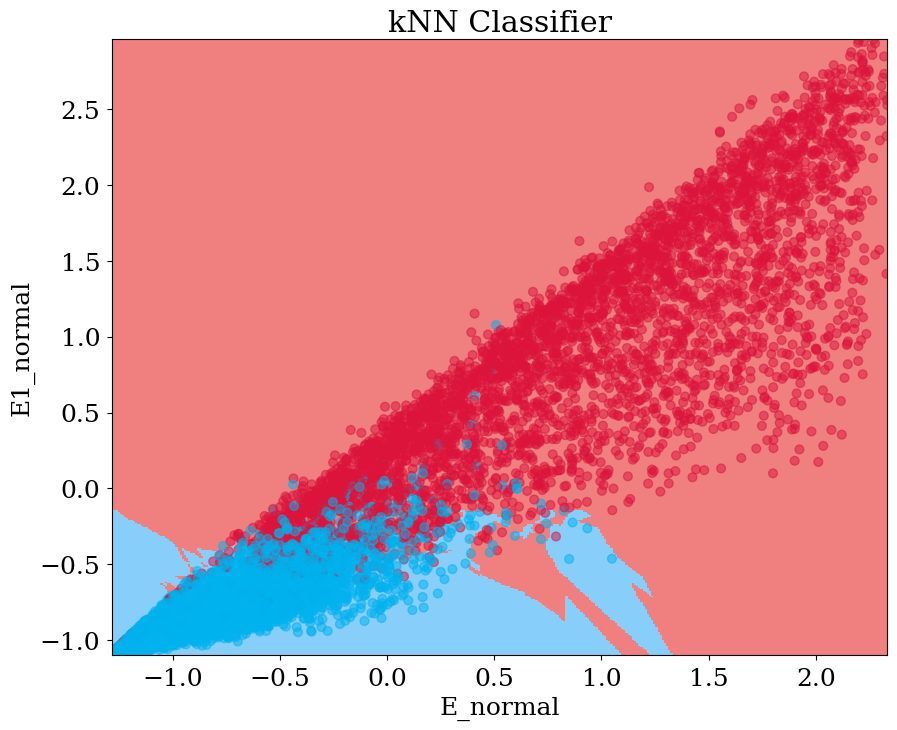

FOM =  63.802767744089024


In [12]:
# Testing the Classify function for the kNN algorithm.

classifier            = 'kNN'
k                     = 5
min_impurity_decrease = 0.3
max_depth             = None
prop_test             = 0.5
feature_list          = ['E_normal', 'E1_normal'] 
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=[k], prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

/Users/matiassantacruz/Documents/Computational Methods/Project_4/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


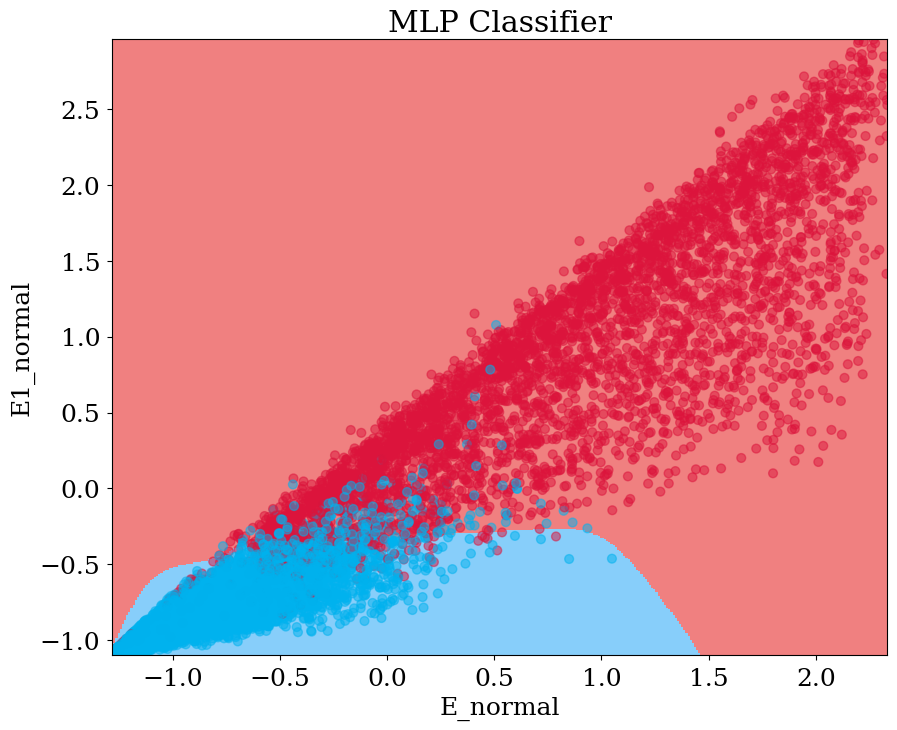

FOM =  63.67387884846072


In [13]:
# Testing the Classify function for the MLP algorithm.

classifier            = 'MLP'
hidden_layers         = (8)
params                = [hidden_layers]
prop_test             = 0.5
feature_list          = ['E_normal', 'E1_normal']
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

/Users/matiassantacruz/Documents/Computational Methods/Project_4/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


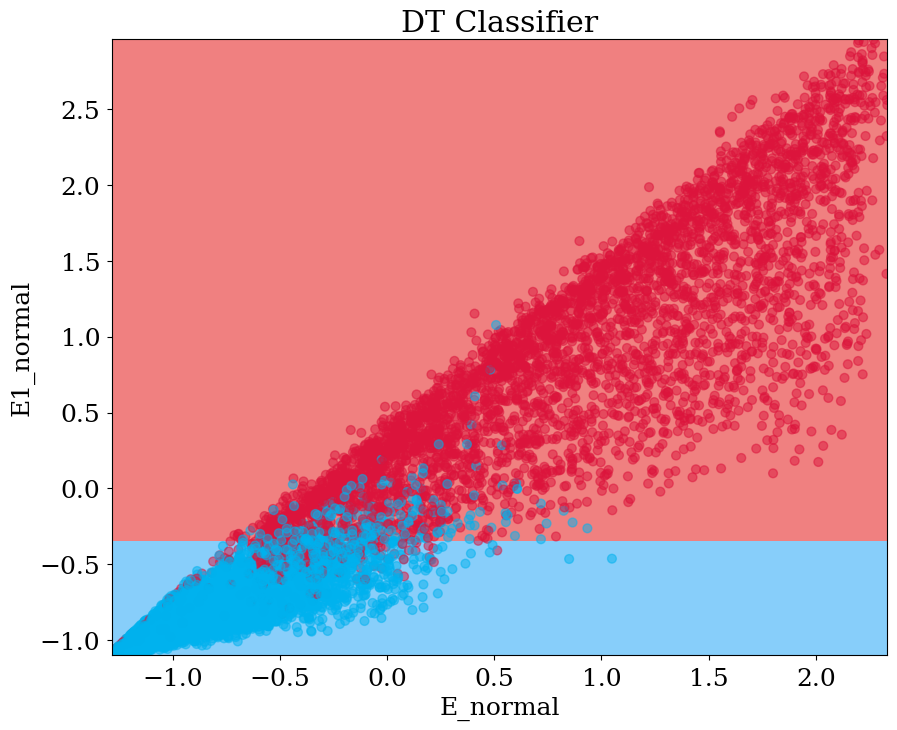

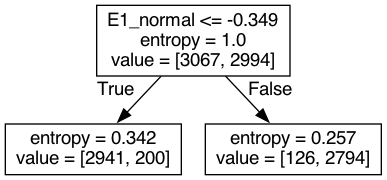

FOM =  63.481977991851075


In [14]:
# Testing the Classify function for the DT algorithm.

classifier            = 'DT'
min_impurity_decrease = 0.3
max_depth             = None
params                = [min_impurity_decrease, max_depth]
prop_test             = 0.3
feature_list          = ['E_normal', 'E1_normal'] 
plot_ds               = True
plot_tree             = True
plot_network          = True

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

/Users/matiassantacruz/Documents/Computational Methods/Project_4/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


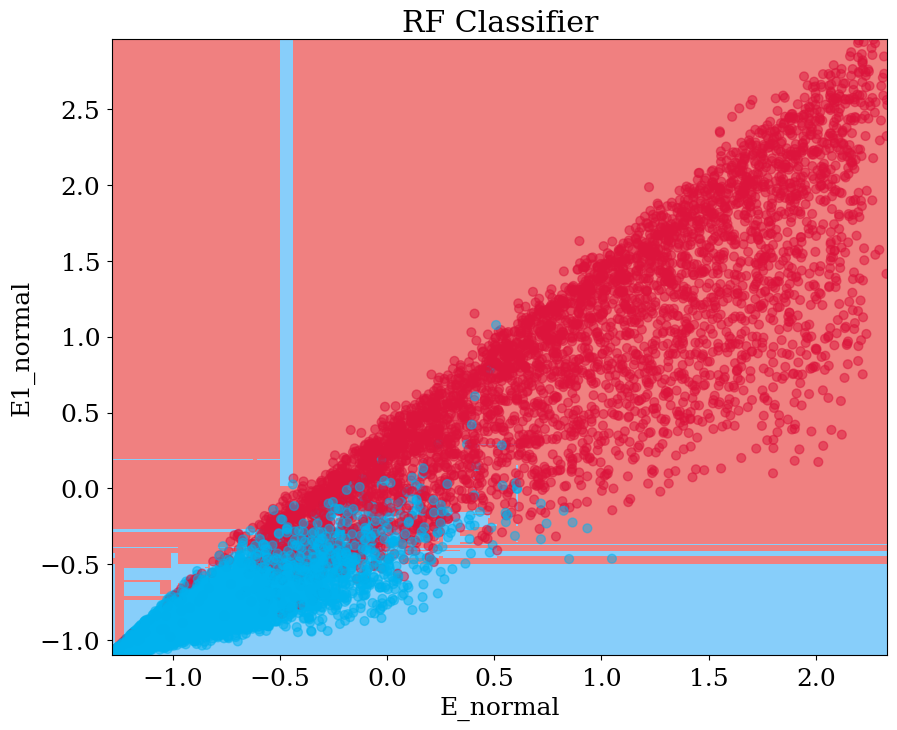

FOM =  64.4189729445845


In [15]:
# Testing the Classify function for the Random Forrest algorithm.

classifier            = 'RF'
n_estimators          = 5
max_features          = 'sqrt'
params                = [n_estimators,max_features]
prop_test             = 0.5
feature_list          = ['E_normal', 'E1_normal']
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

# Choosing a classifier and features

Picking which features are the most powerful ones from the visualisation matrix. As it can be seen the features where the data points are most clearly distinquished are 'E','E1', 'LatMom' and 'NrHits'. From the tests that are run earlier the 'MLP' classifier and the kNN classifier have the highest FOM. Moreover, we ran the code multiple times and thought the FOM was quite high for the Random Forrest Classifier, the surfaces they produced seemed to be overfitting a lot for these particular features. Hence, since they tend to be more or less equal we have chosen the 'MLP' over the kNN classifier to run the data for the rest of the third.

In [16]:
# Visualizing the best number of hidden layers for the MLP Classifier for 
# the E_normal and E1_normal features

FOM_list = []
layer_num = range(1,31)

for i in layer_num:

    classifier            = 'MLP'
    hidden_layers         = i
    params                = [hidden_layers]
    prop_test             = 0.3
    feature_list          = ['E_normal', 'E1_normal']
    plot_ds               = False
    plot_tree             = False
    plot_network          = False



    data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


    FOM_list.append(FOM(data_new))


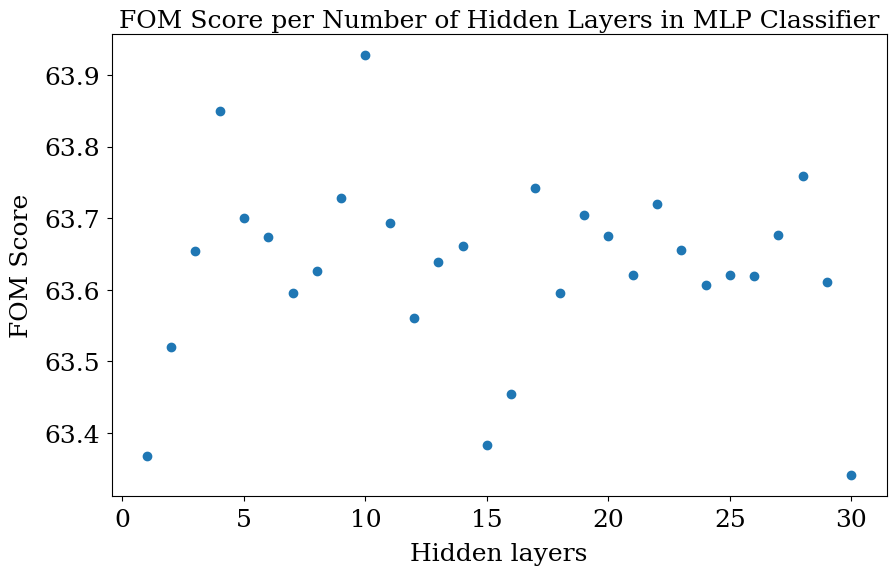

The best param is 10, while the worst is 30


In [17]:
# Finding the best number of hidden layers

plt.figure(figsize=(10, 6))
plt.scatter(layer_num,FOM_list)
plt.xlabel('Hidden layers', labelpad=8)
plt.ylabel('FOM Score', labelpad=8)
plt.title('FOM Score per Number of Hidden Layers in MLP Classifier', size=18, pad=5)
plt.show()

ideal_param = layer_num[FOM_list.index(max(FOM_list))]
worst_param = layer_num[FOM_list.index(min(FOM_list))]

print(f'The best param is {ideal_param}, while the worst is {worst_param}')


/Users/matiassantacruz/Documents/Computational Methods/Project_4/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


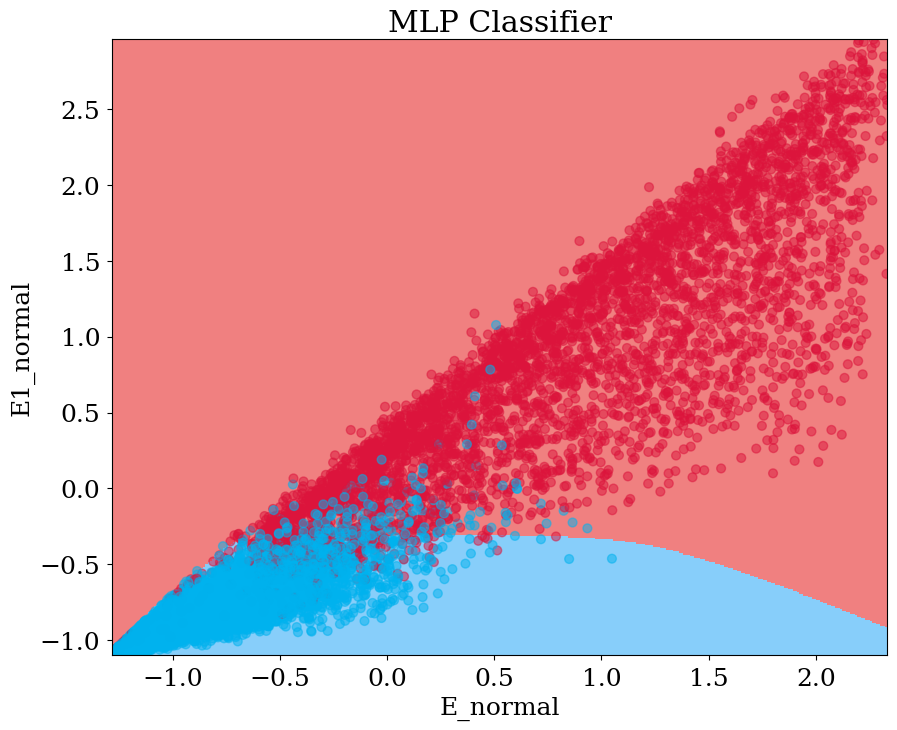

FOM =  63.69737254399469


In [18]:
# Visualizing the decision surface for the parameter with the highest FOM (best parameter)

classifier            = 'MLP'
hidden_layers         = (ideal_param)
params                = [hidden_layers]
prop_test             = 0.5
feature_list          = ['E_normal', 'E1_normal']
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

/Users/matiassantacruz/Documents/Computational Methods/Project_4/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


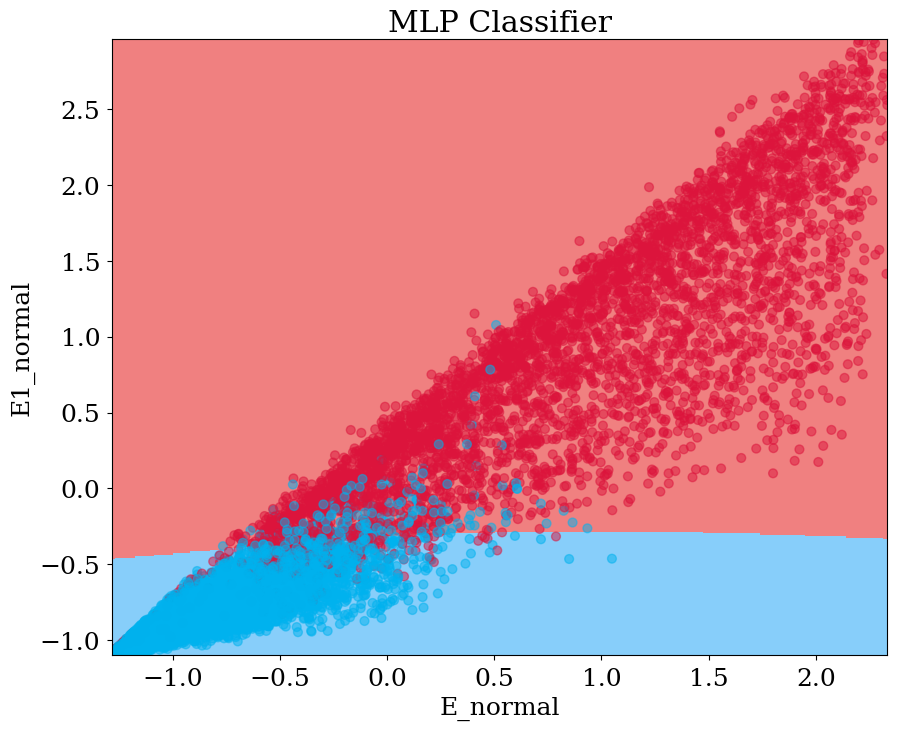

FOM =  63.40130093503108


In [19]:
# Testing for underfitting with the parameter yielding the lowest FOM score

classifier            = 'MLP'
hidden_layers         = (worst_param)
params                = [hidden_layers]
prop_test             = 0.5
feature_list          = ['E_normal', 'E1_normal']
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

## Study the classifier outputs and FOM by varying the list of input features

We found the FOM by applying a range of features to the MLP classifier to train the model. Moreover, we also plotted a few of the decision surfaces for our "importance" features to better understand the behaviour of the classifier.

In [20]:
# Function to test the FOM with different numbers of features in the training.
def FOM_checker(data):
    feature_list = [['E_normal', 'E1_normal'],['E_normal','NrHits_normal'],['E_normal','LatMom_normal'],
                    ['E1_normal','NrHits_normal'],['E1_normal','LatMom'],['NrHits_normal', 'LatMom_normal'],
                    ['E_normal', 'E1_normal','NrHits'],
                    ['E_normal','LatMom_normal','NrHits_normal'],['E_normal', 'LatMom_normal', 'E1_normal'],
                    ['E_normal', 'LatMom_normal', 'E1_normal'],['E_normal','E1_normal','NrHits_normal'],
                    ['E_normal', 'E1_normal', 'NrHits_normal','LatMom']]
    for i in feature_list:
        classifier            = 'MLP'
        hidden_layers         = (ideal_param)
        params                = [hidden_layers]
        prop_test             = 0.5
        data_new = Classify('MLP', data, params=params, prop_test=prop_test, feature_list= i,)
        FOM(data_new)
        print(f'FOM for {i} = ', FOM(data_new))


In [21]:
FOM_checker(plotFrame)

FOM for ['E_normal', 'E1_normal'] =  63.556735611264585
FOM for ['E_normal', 'NrHits_normal'] =  64.27270885869034
FOM for ['E_normal', 'LatMom_normal'] =  63.3783536497251
FOM for ['E1_normal', 'NrHits_normal'] =  64.1909408885976
FOM for ['E1_normal', 'LatMom'] =  63.94841528803225
FOM for ['NrHits_normal', 'LatMom_normal'] =  60.442149778545314
FOM for ['E_normal', 'E1_normal', 'NrHits'] =  64.3791321368238
FOM for ['E_normal', 'LatMom_normal', 'NrHits_normal'] =  63.934397180681565
FOM for ['E_normal', 'LatMom_normal', 'E1_normal'] =  64.24335310876579
FOM for ['E_normal', 'LatMom_normal', 'E1_normal'] =  64.36617694095703
FOM for ['E_normal', 'E1_normal', 'NrHits_normal'] =  63.988650140099516
FOM for ['E_normal', 'E1_normal', 'NrHits_normal', 'LatMom'] =  64.44203626609863


/Users/matiassantacruz/Documents/Computational Methods/Project_4/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


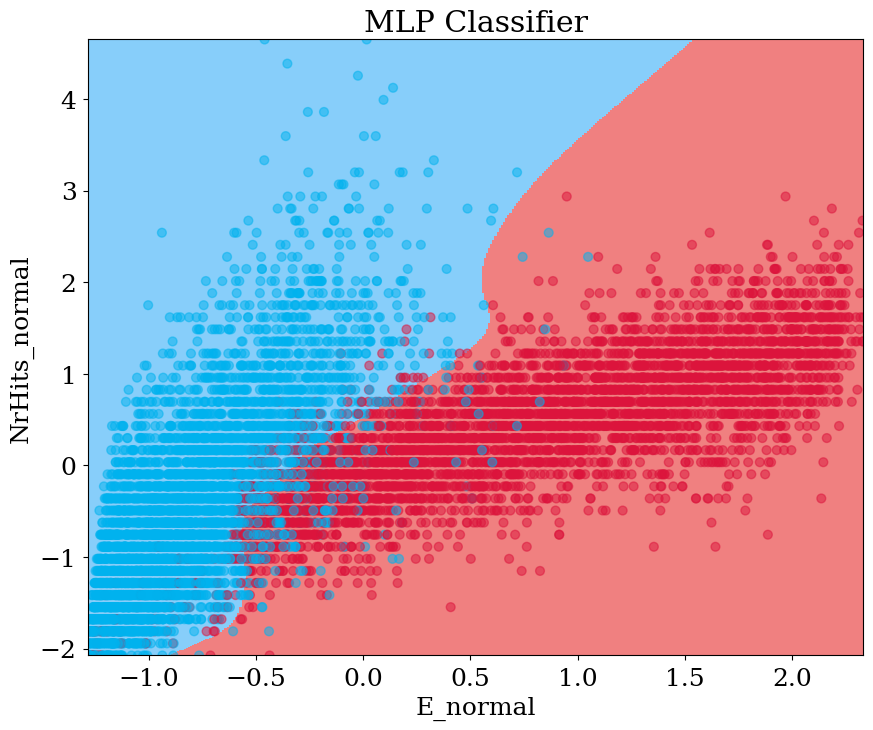

FOM =  63.97788488031617


In [22]:
# Visualizing the decision surface for the parameter with the highest FOM

classifier            = 'MLP'
hidden_layers         = (ideal_param)
params                = [hidden_layers]
prop_test             = 0.5
feature_list          = ['E_normal', 'NrHits_normal']
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

/Users/matiassantacruz/Documents/Computational Methods/Project_4/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


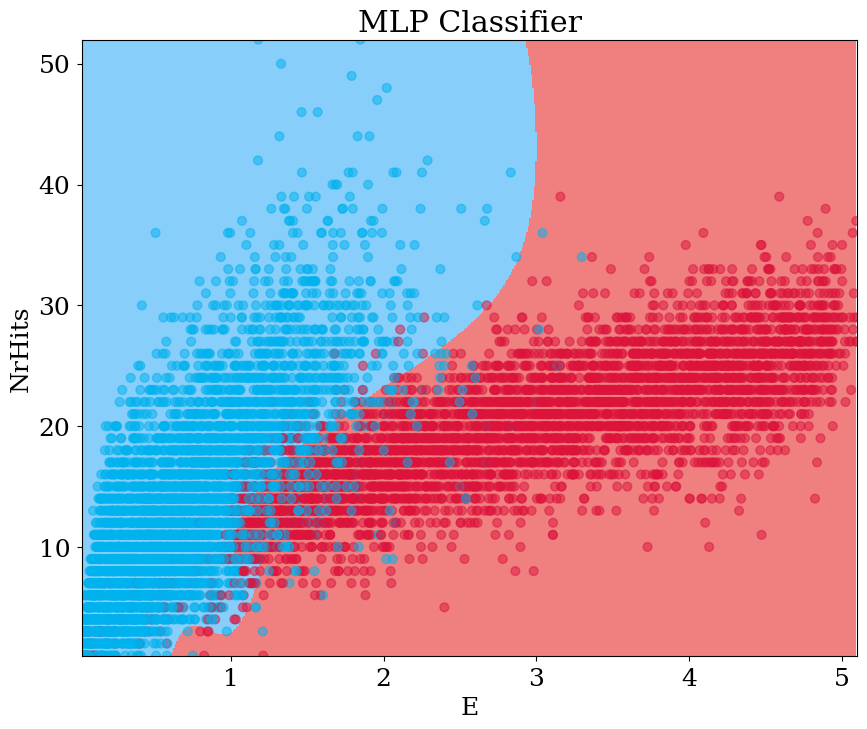

FOM =  64.09880502787976


In [23]:
# Visualizing the decision surface for the parameter with the highest FOM

classifier            = 'MLP'
hidden_layers         = (ideal_param)
params                = [hidden_layers]
prop_test             = 0.5
feature_list          = ['E', 'NrHits']
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

As can be seen from the two cells above, the MLP classifier seems to slightly prefer the normalized version of the data if we only look at the FOM as the measure of success, though the difference is only slight. We ran the code a few times with different, random samples sizes, and found that the surface sometimes looks better (the fit appears to be better despite the FOM score) for the normalized data, and other times it looks better for the raw data.

## Extra: Compare the outcome of two different classifiers

We compare the surfaces and the FOM scores between the kNN Classifier, and the MLP Classifier. We also have a look at the unsupervised centroid based K-Means algorithm compares.

/Users/matiassantacruz/Documents/Computational Methods/Project_4/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


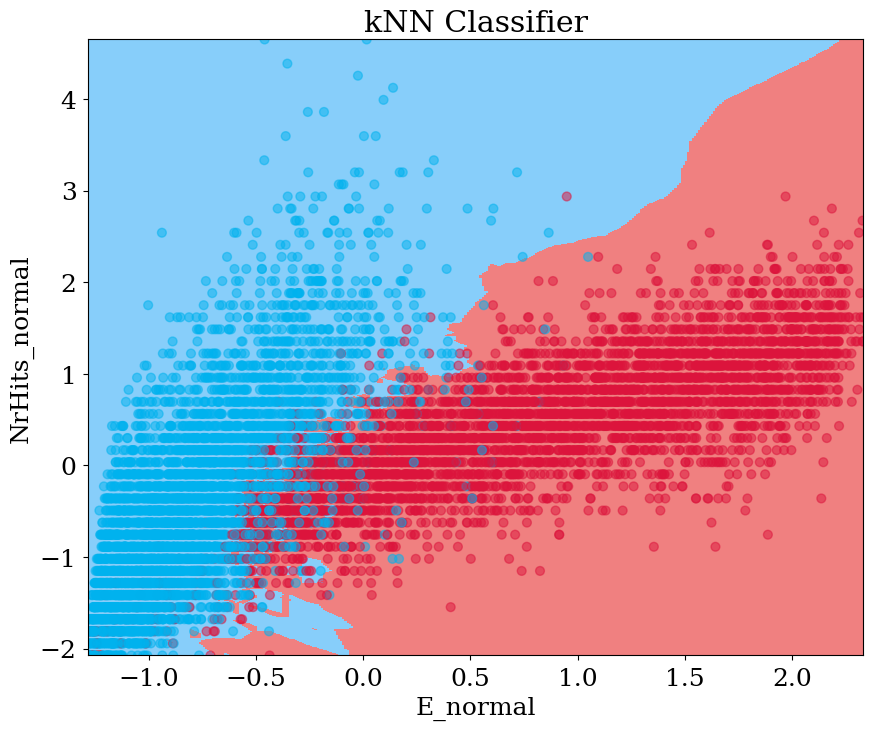

FOM =  63.78530729482961


In [24]:
# Testing the Classify function for the kNN algorithm.

classifier            = 'kNN'
k                     = 5
min_impurity_decrease = 0.3
max_depth             = None
prop_test             = 0.5
feature_list          = ['E_normal', 'NrHits_normal'] 
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=[k], prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

/Users/matiassantacruz/Documents/Computational Methods/Project_4/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


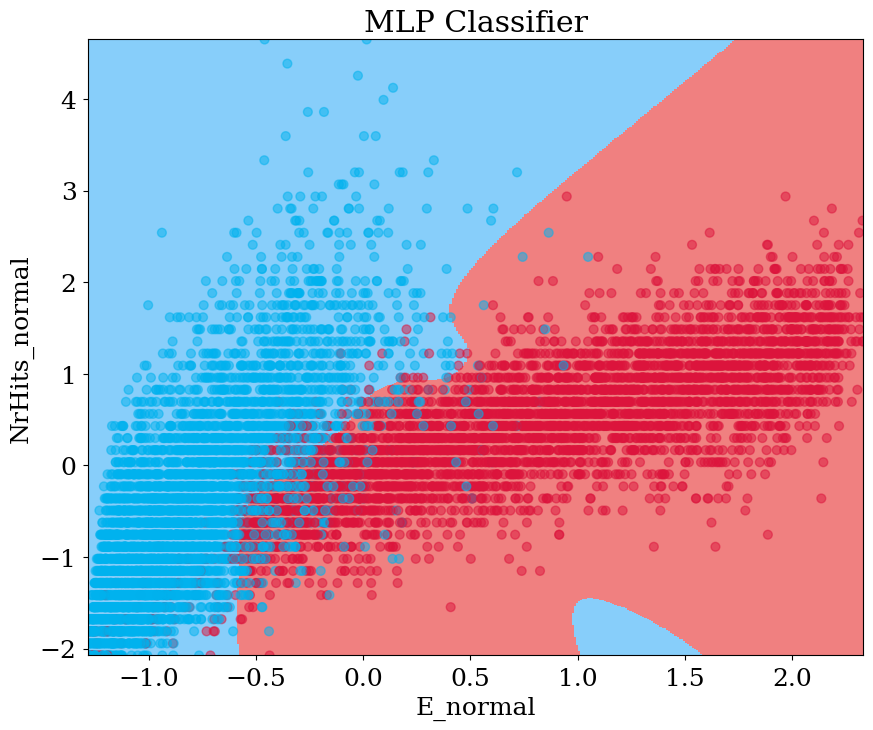

FOM =  64.06660048509286


In [25]:
# Visualizing the decision surface for the parameter with the highest FOM

classifier            = 'MLP'
hidden_layers         = (ideal_param)
params                = [hidden_layers]
prop_test             = 0.5
feature_list          = ['E_normal', 'NrHits_normal']
plot_ds               = True
plot_tree             = False
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)


print('FOM = ', FOM(data_new))

We tested the kNN classifier against the MLP classifer above for the same two features; E_normal and NrHits_normal. We can see that the FOM's are very close at 64.188 against 63.858 respectively. Hence, the MLP classifier is slightly better than the kNN if we soley look at the FOM score, however, the decision surface plotted by the MLP is a lot less jagged and there does not seem to be as much overfitting as the kNN classifier is producing. Of course, this may change if we vary the parameters of both, however, the relationship of these two features seems to be better suited for the MLP classifer.


In [26]:
# K-Means centroid based clustering algorithm (unsupervised)

def getClusters(k, frame, variables):
    '''
    Plots two parameters from a dataframe with cluster centers.
    
    Parameters:
    k (int)                  -- Number of clusters
    frame (pandas dataframe) -- The dataframe to examine
    variables (numpy array)  -- Columns to examine
    '''
    
    start = np.random.rand(k, 2)
    kmeans = cluster.KMeans(n_clusters=k, max_iter=1000, init=start, n_init=1)
    kmeans.fit(frame[variables])
    
    labels    = kmeans.labels_
    centroids = kmeans.cluster_centers_
    nriter    = kmeans.n_iter_
    
    centroids = centroids.reshape(k, 2)
    centroidFrame = pd.DataFrame(centroids, columns =['x', 'y'])
    
    fig, axes = plt.subplots(nrows=1, ncols=1,
                            figsize=(10, 8),
                            layout="constrained"
                            )

    sns.scatterplot(data=frame, x=variables[0], y=variables[1], marker='.', hue='distinction', ax=axes).set_title(f'{variables[0]} v.s. {variables[1]}')
    sns.scatterplot(data=centroidFrame, x='x', y='y', marker='X', color='black', s=200, ax=axes)
    plt.show()


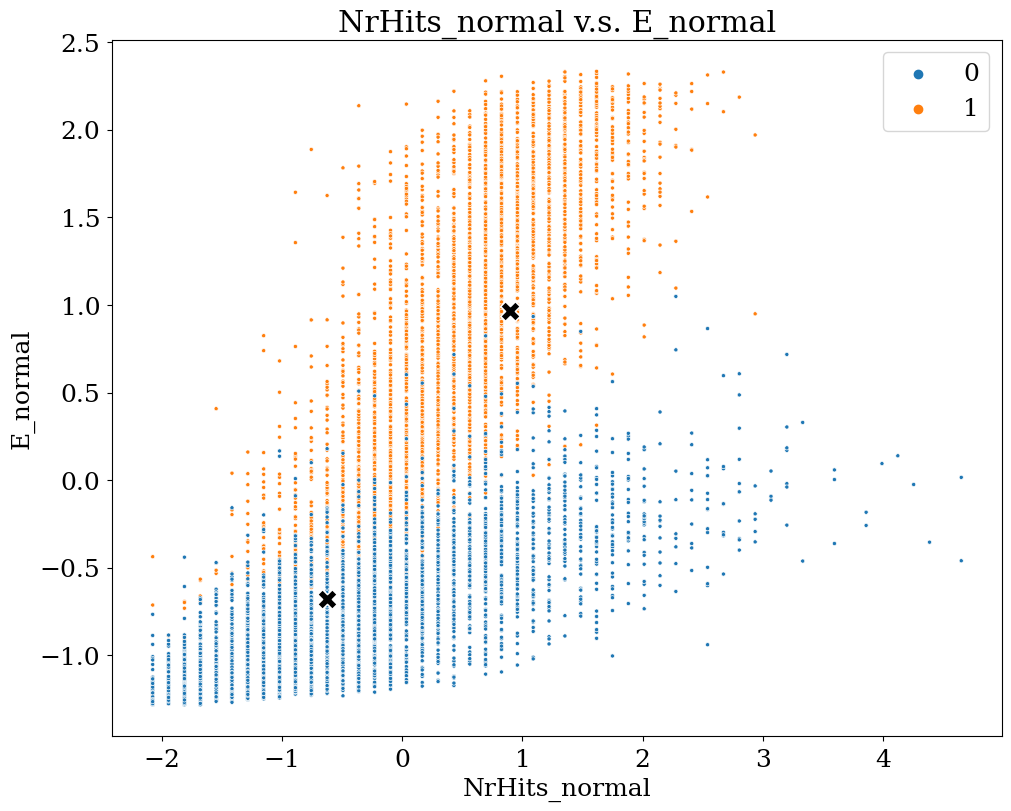

In [27]:
getClusters(2, plotFrame, ['NrHits_normal', 'E_normal'])

In machine learning, there is a very interesting challenge in comparing the quality of the classification result generated by either unsupervised or supervised classifiers. Most of the time, we opt for one technique over the other. Sometimes, we perform a comparison study and use a visual examination to decide which classifier produced the best outcome.

We ran the code for a few of the features, and found that in general the unsupervised method and supervised method produce results of varying similarity. If the neutrons and photons have more clear boundaries and are arranged in easy to see clusters, then the differences are not extremely different. In general, the more complex the distribution of the data between the photons and neutrons, the better the supervised methods seem to behave; they produce better fitting surfaces.

# Citations

A large number of the functions in this notebook were inspired by J.G. Messchendorp's notebook on Machine Learning written in October 2020, most notably the 'Classify' function. For reference, his original notebook can be found here:

https://github.com/diodeamy/ComputationalMethods/blob/main/Project%204/4_Demo3.ipynb